In [12]:
# Loading packages
import numpy as np
import sdeint
import deepdish.io as dd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython.display import set_matplotlib_formats
from ipywidgets import interact, interactive,FloatSlider,IntSlider,ToggleButton
from ipywidgets import Button, HBox, VBox, Text,Select,Layout,Dropdown
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"
from rmModel_py3 import rmModel,Es_normal
m = rmModel(Es=Es_normal,Ps='auto/rm_set1.hdf5',Vs=None)
forcing = 0.5*(1.0+a*np.sin(tspan*2.0*np.pi))

dxdt =  -c*x*y/(b + x) + r*x*(1.0 - x/K)
dydt =  c*e*x*y*(a*sin(6.28318530717959*omegaf*t) + 1.0)/(b + x) - d*y
Local Jacobian: Matrix([[c*x*y/(b + x)**2 - c*y/(b + x) + r*(1.0 - x/K) - r*x/K, -c*x/(b + x)], [-c*e*x*y*(a*sin(6.28318530717959*omegaf*t) + 1.0)/(b + x)**2 + c*e*y*(a*sin(6.28318530717959*omegaf*t) + 1.0)/(b + x), c*e*x*(a*sin(6.28318530717959*omegaf*t) + 1.0)/(b + x) - d]])
Time to setup:  9.856779336929321


In [14]:
p=m.p.copy()
print(p)
e_hopf = p['d']*(p['K']+p['b'])/(p['c']*(p['K']-p['b']))
e_trans = p['d']*(p['K']+p['b'])/(p['c']*p['K'])
print(e_trans,'-',e_hopf)

{'K': 1.0, 'a': 0.0, 'b': 0.3, 'c': 12.566370614359172, 'd': 6.283185307179586, 'e': 1.0, 'omegaf': 1.0, 'r': 6.283185307179586}
0.65 - 0.9285714285714286


In [15]:
# Plot time series without stochasticity
def plotRM(e,a,finish,trim,save):
    tspan,result = m.ode_integrate('stable_state',step=0.1,finish=finish,e=e,a=a)
    #m.print_equations(True)
    #print m.p['e']
    plt.figure(figsize=(1.618*6,6))
    plt.plot(tspan,result[:,0],label=r'prey')
    plt.plot(tspan,result[:,1],label=r'predator')
    #plt.plot(tspan,np.sin(tspan*np.pi/(100.0/7.0)),label=r'sin')
    plt.xlabel(r't')
    plt.xlim([trim,tspan[-1]])
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save:
        plt.savefig('results/RM_e{:3.2f}_a{:3.2f}'.format(e,a).replace('.','_')+'.png')

save_w =ToggleButton(value=False,description='Save fig',disabled=False,
                     button_style='', # 'success', 'info', 'warning', 'danger' or ''
                     tooltip='Description',
                     icon='check')
e_w = FloatSlider(min=0.0,max=2.0,step=0.01,value=e_hopf-0.01)
a_w = FloatSlider(min=0.0,max=1.0,step=0.01,value=0.0)
tspan_w = FloatSlider(min=0.0,max=500.0,step=50.0,value=100.0)
trim_w = FloatSlider(min=0.0,max=500.0,step=50.0,value=0.0)
interact(plotRM,e=e_w,a=a_w,finish=tspan_w,trim=trim_w,save=save_w)  

interactive(children=(FloatSlider(value=0.9185714285714286, description='e', max=2.0, step=0.01), FloatSlider(…

<function __main__.plotRM(e, a, finish, trim, save)>

a=0.1
e=0.9185714285714286


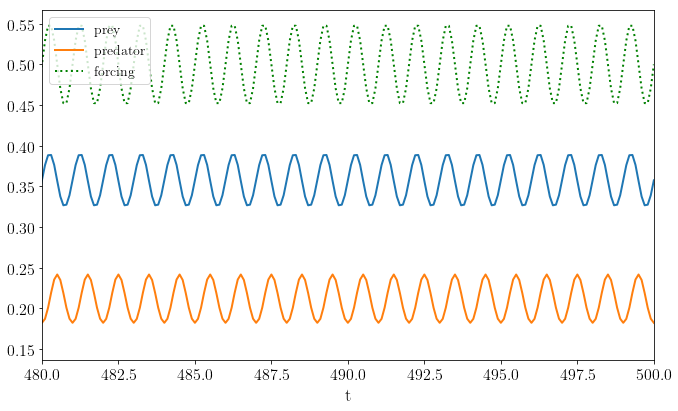

In [16]:
e=e_hopf-0.01
a=0.1
finish=500
trim=480
tspan,result = m.ode_integrate('stable_state',step=0.1,finish=finish,e=e,a=a)
#m.print_equations(True)
#print m.p['e']
plt.figure(figsize=(1.618*6,6))
plt.plot(tspan,result[:,0],label=r'prey')
plt.plot(tspan,result[:,1],label=r'predator')
plt.plot(tspan,0.5*(1.0+a*np.sin(tspan*2.0*np.pi)),'g:',label=r'forcing')
plt.xlabel(r't')
plt.xlim([trim,tspan[-1]])
plt.legend(loc='upper left')
plt.tight_layout()

a=1.0
e=0.7892857142857144


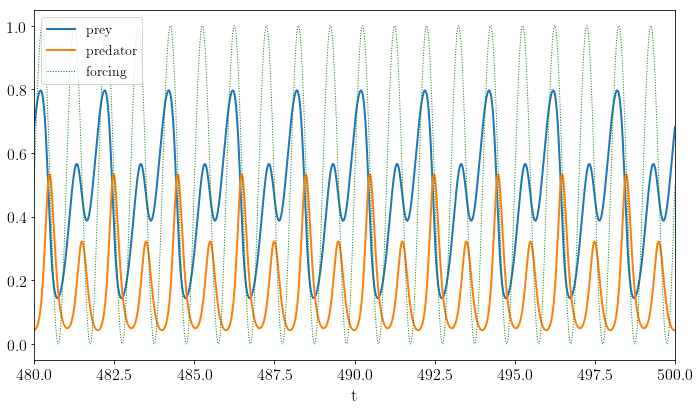

In [23]:
e=(e_hopf + e_trans)/2.0
a=1.0
finish=500
ito=0.000
trim=480
parameters={}
parameters['e']=e
parameters['a']=a
m.update_parameters(parameters)
def G(y, t):
    return np.array([[ito, 0.0],[0.0, ito]])
step=0.01
tspan = np.arange(0.0, finish+step,step)
result = sdeint.itoint(m.rhs_ode, G, m.calc_stable_state(), tspan)
#plt.figure(figsize=(1.618*6,6))
plt.plot(tspan,result[:,0],label=r'prey')
plt.plot(tspan,result[:,1],label=r'predator')
plt.plot(tspan,0.5*(1.0+a*np.sin(tspan*2.0*np.pi)),'g:',label=r'forcing',lw=1)
plt.xlabel(r't')
plt.xlim([trim,tspan[-1]])
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('results/RM_Ito_e{:3.2f}_a{:3.2f}_ito{:4.3f}'.format(e,a,ito).replace('.','_')+'.pdf')
#plt.savefig('results/RM_Ito_e{:3.2f}_a{:3.2f}_ito{:4.3f}'.format(e,a,ito).replace('.','_')+'.png')

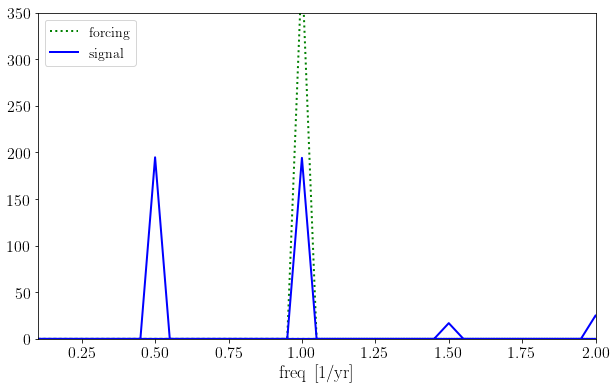

In [24]:
trim = 2000
frq = np.fft.fftfreq(forcing[-trim:].size,d=0.01)
plt.plot(frq[1:],np.absolute((np.fft.fft(forcing[-trim:])))[1:],'g:',label=r'forcing')
plt.plot(frq[1:],np.absolute((np.fft.fft(result[-trim:,0])))[1:],'b',label=r'signal')
plt.xlim([0.1,2])
plt.ylim([0.1,350])
plt.xlabel(r'freq\, [1/yr]')
plt.legend(loc='upper left')
plt.savefig('results/fft_RM_Ito_e{:3.2f}_a{:3.2f}_ito{:4.3f}'.format(e,a,ito).replace('.','_')+'.pdf')
plt.savefig('results/fft_RM_Ito_e{:3.2f}_a{:3.2f}_ito{:4.3f}'.format(e,a,ito).replace('.','_')+'.png')

a=0.0
e=0.9385714285714286
a=0.7
e=0.7892857142857144


IndexError: invalid index to scalar variable.

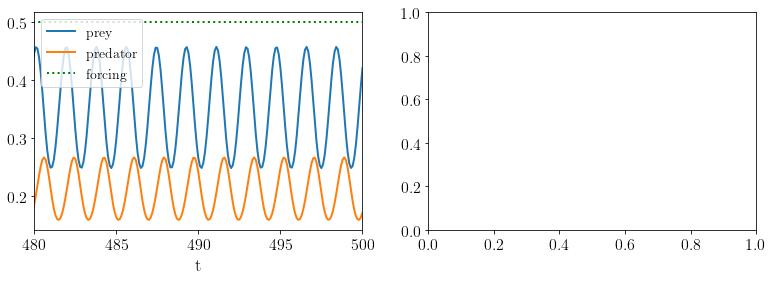

In [18]:
# Compare Hopf to forced
fig,ax = plt.subplots(1,2,figsize=(2*1.618*4,4))
e=e_hopf+0.01
a=0.0
finish=500
trim=480
tspan,result = m.ode_integrate('stable_state',step=0.1,finish=finish,e=e,a=a)
#m.print_equations(True)
ax[0].plot(tspan,result[:,0],label=r'prey')
ax[0].plot(tspan,result[:,1],label=r'predator')
ax[0].plot(tspan,0.5*(1.0+a*np.sin(tspan*2.0*np.pi)),'g:',label=r'forcing')
ax[0].set_xlabel(r't')
ax[0].set_xlim([trim,tspan[-1]])
ax[0].legend(loc='upper left')
e=(e_hopf + e_trans)/2.0
a=0.7
finish=500
ito=0.000
trim=480
parameters={}
parameters['e']=e
parameters['a']=a
m.update_parameters(parameters)
#def G(y, t):
#    return np.array([[ito, 0.0],[0.0, ito]])
def G(y, t):
    sigma = ito*m.p['e']*m.predation(y,t)
    return np.array([[0.0, 0.0],[0.0, sigma]])
step=0.01
tspan = np.arange(0.0, finish+step,step)
result = sdeint.itoint(m.rhs_ode, G, m.calc_stable_state(), tspan)
#plt.figure(figsize=(1.618*6,6))
ax[1].plot(tspan,result[:,0],label=r'prey')
ax[1].plot(tspan,result[:,1],label=r'predator')
ax[1].plot(tspan,0.5*(1.0+a*np.sin(tspan*2.0*np.pi)),'g:',label=r'forcing',lw=1)
ax[1].set_xlabel(r't')
ax[1].set_xlim([trim,tspan[-1]])
ax[1].legend(loc='upper left')
plt.tight_layout()
#plt.savefig('results/RM_Ito_e{:3.2f}_a{:3.2f}_ito{:4.3f}'.format(e,a,ito).replace('.','_')+'.pdf')
#plt.savefig('results/RM_Ito_e{:3.2f}_a{:3.2f}_ito{:4.3f}'.format(e,a,ito).replace('.','_')+'.png')

a=0.7
e=0.7892857142857144


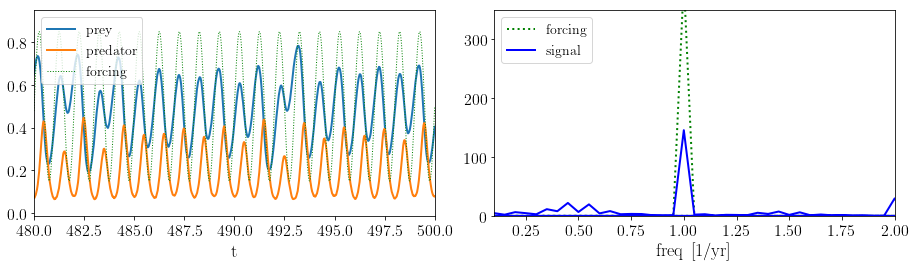

In [36]:
e=(e_hopf + e_trans)/2.0
a=0.7

finish=500
ito=0.01
trim=480
parameters={}
parameters['e']=e
parameters['a']=a
m.update_parameters(parameters)
def G(y, t):
    return np.array([[ito, 0.0],[0.0, ito]])
step=0.01
tspan = np.arange(0.0, finish+step,step)
result = sdeint.itoint(m.rhs_ode, G, m.calc_stable_state(), tspan)
fig,ax=plt.subplots(1,2,figsize=(2*4*1.618,4))
ax[0].plot(tspan,result[:,0],label=r'prey')
ax[0].plot(tspan,result[:,1],label=r'predator')
ax[0].plot(tspan,0.5*(1.0+a*np.sin(tspan*2.0*np.pi)),'g:',label=r'forcing',lw=1)
ax[0].set_xlabel(r't')
ax[0].set_xlim([trim,tspan[-1]])
# fft
trim = 2000 # the index from which to trim the time series to clean transients
frq = np.fft.fftfreq(forcing[-trim:].size,d=0.01)
ax[1].plot(frq[1:],np.absolute((np.fft.fft(forcing[-trim:])))[1:],'g:',label=r'forcing')
ax[1].plot(frq[1:],np.absolute((np.fft.fft(result[-trim:,1])))[1:],'b',label=r'signal')
ax[1].set_xlim([0.1,2])
ax[1].set_ylim([0.1,350])
ax[1].set_xlabel(r'freq\, [1/yr]')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.tight_layout()

In [ ]:
# Plot time series with stochasticity
def plotRM_Ito(e,a,ito,finish,save):
    parameters={}
    parameters['e']=e
    parameters['a']=a
    m.update_parameters(parameters)
    def G(y, t):
        return np.array([[ito, 0.0],[0.0, ito]])
    step=0.01
    tspan = np.arange(0.0, finish+step,step)
    result = sdeint.itoint(m.rhs_ode, G, m.calc_stable_state(), tspan)
    plt.figure(figsize=(1.618*6,6))
    plt.plot(tspan,result[:,0],label=r'prey')
    plt.plot(tspan,result[:,1],label=r'predator')
    #plt.plot(tspan,np.sin(tspan*np.pi/(100.0/7.0)),label=r'sin')
    plt.xlabel(r't')
    plt.xlim([tspan[0],tspan[-1]])
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save:
        plt.savefig('results/RM_Ito_e{:3.2f}_a{:3.2f}'.format(e,a).replace('.','_')+'.png')

save_w =ToggleButton(value=False,description='Save fig',disabled=False,
                     button_style='', # 'success', 'info', 'warning', 'danger' or ''
                     tooltip='Description',
                     icon='check')
e_w = FloatSlider(min=0.0,max=2.0,step=0.01,value=e_hopf-0.01)
a_w = FloatSlider(min=0.0,max=1.0,step=0.01,value=0.0)
tspan_w = FloatSlider(min=0.0,max=500.0,step=10.0,value=500.0)
ito_w = FloatSlider(min=0.0,max=0.1,step=0.01,value=0.00)
interact(plotRM_Ito,e=e_w,a=a_w,ito=ito_w,finish=tspan_w,save=save_w)  

In [ ]:
# Rosenzweig - MacArthur Model Ito stochastic integration
B = np.array([[0.01, 0.0],
              [0.0, 0.01]])

tspan = np.linspace(0.0, 1000.0, 100001)
y0 = np.array([1., 1.0])

r=1.0
K=2.
a=1.
h=0.1
e=0.1
d=0.1
g=0.1

def f_scipy(t,y):
    return f(y,t)

def f(y, t):
    """ Return the growth rate of fox and rabbit populations. """
    forcing=(1.0+g*np.sin(t*np.pi/(100.0/7.0)))
    return np.array([y[0] * ( r*(1-y[0]/K) - a*y[1]/(1+a*h*y[0]) ),
                     y[1] * (forcing*e*a*y[0]/(1+a*h*y[0]) - d) ])

def G(y, t):
    return B


def itointRM(y0,start,finish,step,r,K,a,h,w,d,g,B):
    B = np.array([[0.0, 0.0],
              [0.0, 0.0001]])
    tspan = np.linspace(0.0, 1000.0, 100001)
    y0 = np.array([1., 1.0])
    
    def f(y, t):
        """ Return the growth rate of fox and rabbit populations. """
        forcing=(1.0+g*np.sin(t*np.pi/(100.0/7.0)))
        return np.array([y[0] * ( r*(1-y[0]/K) - a*y[1]/(1+a*h*y[0]) ),
                         y[1] * (forcing*e*a*y[0]/(1+a*h*y[0]) - d) ])
    def G(y, t):
        return B
    
    return tspan,sdeint.itoint(f, G, y0, tspan)



In [ ]:
result = sdeint.itoint(f, G, y0, tspan)

In [ ]:
plt.figure(figsize=(1.618*6,6))
plt.plot(tspan,result[:,0],label=r'prey')
plt.plot(tspan,result[:,1],label=r'predator')
#plt.plot(tspan,np.sin(tspan*np.pi/(100.0/7.0)),label=r'sin')
plt.xlabel(r't')
plt.xlim([tspan[0],tspan[-1]])
plt.legend(loc='best')
#plt.savefig('rosenzweig-macarthur-ito.png')